# Warning: the dataset is a few gigabytes. My method of loading the data to a pandas dataframe is not very space efficient, which results in this notebook using a bunch of memory. I will try to improve, but in the meantime be careful.

# Exploration of Google Analytics for Google Merchandise Store

- Data: Customer data for GStore (provided on Kaggle)
- Performance: Measured by the percentage of sessions that ended in purchases.
- Main questions:
    - What are the main sources where potential customers come from? 
    - How do their performances compare?
- Methodology:
    - Graphs
- Conclusions:
    - Major purchases come from referrals (from mall.googleplex.com)
    - Sessions from social networks and social medias performs poorly.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# from plotly import tools
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

/Users/fanggot/anaconda/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
import datetime
from matplotlib.pyplot import show
import statsmodels.api as sm

/Users/fanggot/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data wrangling and cleaning
- Import the data
- Unfold the columns that contains JSON 
- Drop constant columns
- Format the data to correct type (e.g datetime, float, ... etc)
- Fill some NaN values where justified

In [3]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [column + "." + subcolumn for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
#     print(f'Loaded {os.path.basename(csv_path)}. Shape: {df.shape}')
    return df

In [4]:
train_df = load_df("train.csv")

In [5]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

In [6]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [7]:
cols_to_drop = const_cols + ['sessionId']
train_df = train_df.drop(cols_to_drop, axis=1)

In [8]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [9]:
train_df['date']=train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [10]:
train_df['date']=pd.to_datetime(train_df['date'])

In [11]:
train_df["totals.transactionRevenue"].fillna(0, inplace=True)

In [12]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)

In [13]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

## How many sessions ended in purchases?

In [14]:
train_df['spent_bool'] = train_df['totals.transactionRevenue'] > 0

In [15]:
train_df['spent_bool'].value_counts()

False    892138
True      11515
Name: spent_bool, dtype: int64

In [16]:
11515/903653

0.0127427231470487

### Only ~1.3% of sessions end in a purchase

In [289]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(train_df['spent_bool'].value_counts().index, train_df['spent_bool'].value_counts().values, ax = ax)
ax.set_title('Counts of sessions by whether they ended in purchases')


/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



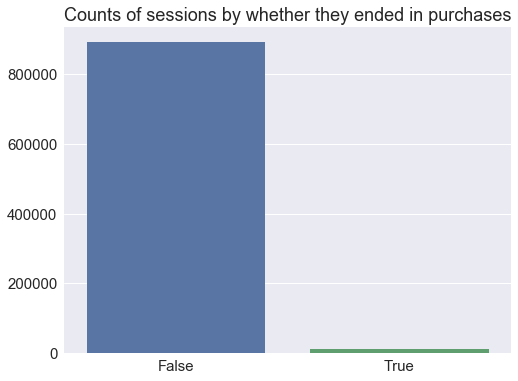

In [290]:
show()

## Exploring purchases versus time
- Construct time series for the revenue, number of sessions, and number of purchasing sessions.
- Decompose the time series using additive model to recover trends, seasonality, and residue.

In [18]:
date_rev = train_df.groupby(by=['date']).sum()['totals.transactionRevenue']
date_sessions = train_df.groupby(by=['date']).count()['totals.transactionRevenue']
date_spending_sessions = train_df.groupby(by=['date']).sum()['spent_bool']

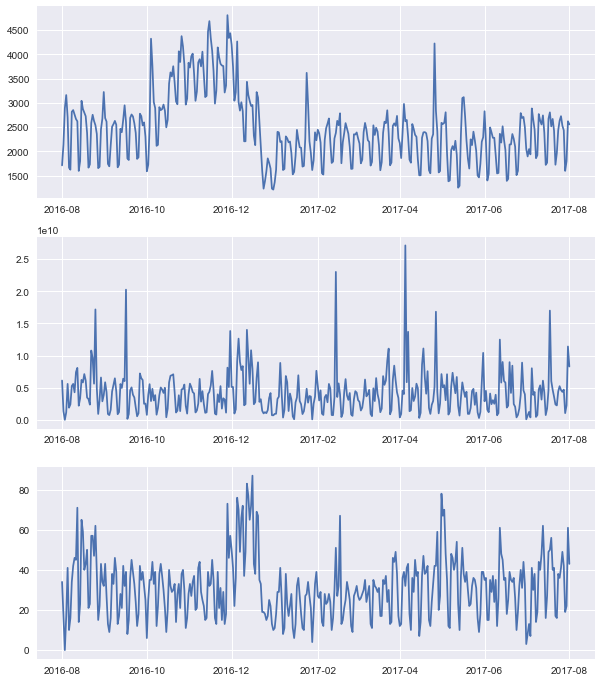

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,12))
axes[0].plot(date_sessions.index, date_sessions.values)
axes[1].plot(date_rev.index, date_rev.values)
axes[2].plot(date_spending_sessions.index, date_spending_sessions.values)
show()

#### Time series for the amount of sessions that ended in purchases

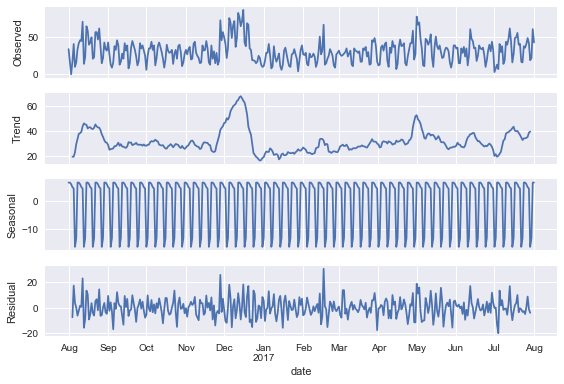

In [20]:
df = pd.DataFrame(date_spending_sessions)
df.index = pd.to_datetime(df.index)
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

### Takeaways:
- There is a strong seasonality (turns out to be weekly, which we will explore below).
- During the holiday seasons (around December), there are more sessions that ended in purchases.

#### Time series for revenue

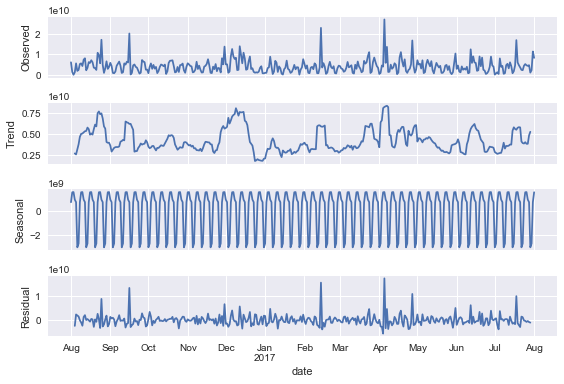

In [21]:
df = pd.DataFrame(date_rev)
df.index = pd.to_datetime(df.index)
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

### Takeaways:
- There is again a strong seasonality (turns out to be weekly, which we will explore below).
- During the holiday seasons (around December), there is an increase in revenue.
- However, there are a lot more bumps (compared to the number of buying sessions) probably due to the fact that a user could spend a lot during a session.

### Exploration of where the seasonality come from

In [22]:
train_df['weekday'] = train_df['date'].dt.dayofweek

In [69]:
dayofweek_spent = train_df.groupby(by=['weekday']).sum()['spent_bool']
dayofweek_spent_p = train_df.groupby(by=['weekday']).mean()['spent_bool']
dayofweek_spent_r = train_df.groupby(by=['weekday']).sum()['totals.transactionRevenue']

#### Plot of the number of sessions that ended in purchases, versus the day of the week

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


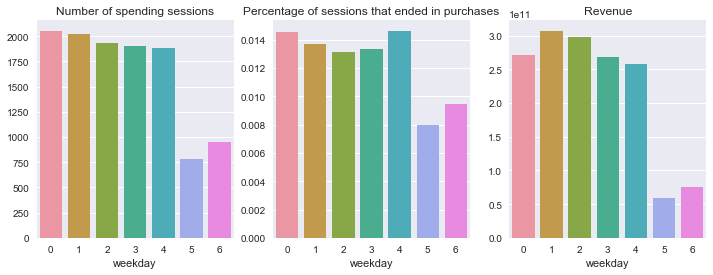

In [95]:
fix, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
sns.barplot(dayofweek_spent.index, dayofweek_spent.values, ax= ax1)
sns.barplot(dayofweek_spent_p.index, dayofweek_spent_p.values, ax= ax2)
sns.barplot(dayofweek_spent_r.index, dayofweek_spent_r.values, ax= ax3)
ax1.set_title('Number of spending sessions')
ax2.set_title('Percentage of sessions that ended in purchases')
ax3.set_title('Revenue')
show()

### Takeaways:
- There is a big drop during the weekends, where
    - There are less sessions that ended in purchases
    - The percentage of sessions that ended in purchases is lower
    - The net revenue is lower.

In [25]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,spent_bool,weekday
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1.0,1.472830e+09,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,False,4
1,Organic Search,2016-09-02,377306020877927890,1472880147,1.0,1.472880e+09,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,False,4
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1.0,1.472865e+09,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,False,4
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1.0,1.472881e+09,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google,False,4
4,Organic Search,2016-09-02,27294437909732085,1472822600,2.0,1.472823e+09,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google,False,4


## Channel Grouping:
- Organic Search, Social, Direct, Referral, Paid Search, Affiliates, Display
    - Direct: direct, not set, none
    - Organic Search: search engine results
    - Social: social network and social media
    - Referral: e.g. through a link on another domain
    - Paid Search: cpc (cost per click), ppc (pay per click), paidsearch
    - Affiliates
    - Display: cpm (Cost-per-thousand impressions), banner

In [26]:
train_df['channelGrouping'] = train_df['channelGrouping'].astype('category')

In [27]:
train_df['channelGrouping'].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

In [200]:
cG_count= train_df.groupby(by=['channelGrouping']).count()['spent_bool'].sort_values(ascending = False)
cG_count.index = [i for i in cG_count.index]
cG_spend_percent = train_df.groupby(by=['channelGrouping']).mean().loc[cG_count.index,['spent_bool']]['spent_bool']
cG_spend_percent.index = cG_count.index
# cG_spend_count = train_df[train_df['spent_bool'] == True].groupby(by=['channelGrouping']).count()['date']

# I should probably sort this

In [97]:
import plotly.plotly as py

In [283]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,8))
# sns.barplot(cG_count.values,cG_count.index, ax = ax1)
# ax1.set_title('Counts of sessions by channel grouping')
g = sns.barplot(cG_spend_percent.values,cG_spend_percent.index, ax = ax)
ax.set_title('Percentage of sessions that ended in purchases')
for i, v in enumerate(cG_count):
    g.text(.055, i, '{:.1f}'.format(cG_spend_percent.values[i]*100) + '% of ' + str(v))
# for index, row in groupedvalues.iterrows():
#     print()
#     g.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")
ax.set_title('Percentage of sessions spending, grouped by channels')

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



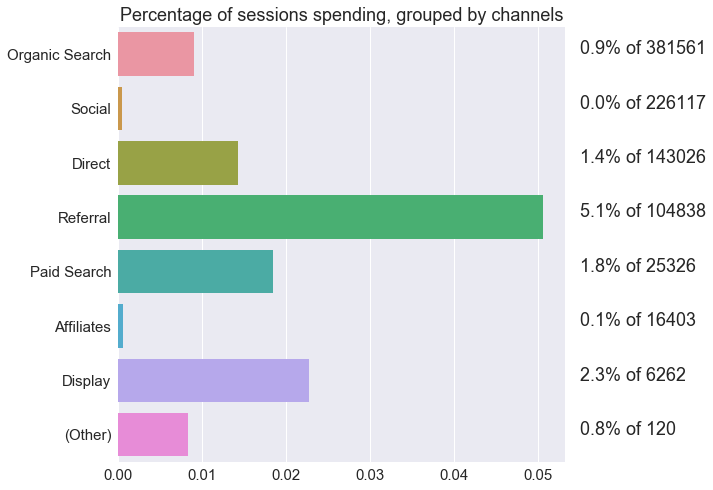

In [284]:
show()

### summary
- Sessions coming from social channels very rarely result in purchases.
- Referral sessions have both the highest probability of resulting in a purchase and occupies the largest fraction of the spending sessions.
- Details on Social, Referral, Paid Search, and Display next
- No keyword data nor direct data

### Exploration of the number of visits versus how likely they will spend some money

In [34]:
vN_spent = pd.DataFrame({'visit_num': pd.cut(train_df['visitNumber'], bins=10), 
             'spent_bool': train_df['spent_bool'].values})

In [35]:
vN_spent_percent = vN_spent.groupby(by=['visit_num']).mean()['spent_bool']

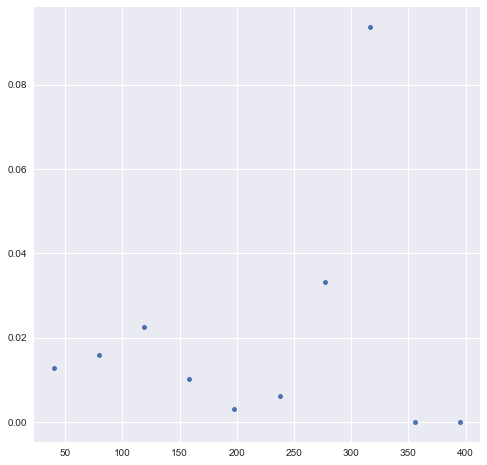

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([i.right for i in vN_spent_percent.index], vN_spent_percent.values, 'o', markersize=5)
show()

### I wasn't able to distill too clear of a trend. I skip this in the slides

## Lets explore how traffic source relates to spending probability

In [205]:
train_df['trafficSource.medium'].value_counts()

organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: trafficSource.medium, dtype: int64

In [139]:
train_df['trafficSource.source'] = train_df['trafficSource.source'].astype('category')
train_df['trafficSource.medium'] = train_df['trafficSource.medium'].astype('category')

In [42]:
train_df.loc[train_df['spent_bool'] == True]['trafficSource.medium'].value_counts()

referral     5415
organic      3438
(none)       2042
cpc           468
cpm           142
affiliate       9
(not set)       1
Name: trafficSource.medium, dtype: int64

In [43]:
top_spent_source = train_df.loc[train_df['spent_bool'] == True]['trafficSource.source'].value_counts()[:10]

In [113]:
top_source = train_df.groupby(by=['trafficSource.source']).count().nlargest(10,'spent_bool')['spent_bool']
top_index = [i for i in top_source.index[:10]]
top_source.index = top_index

In [127]:
top_source_T = train_df.groupby(by=['trafficSource.source']).sum().loc[top_index,['spent_bool']]['spent_bool']
top_source_T.index = topindex

### We will explore the source of traffic by site.
- What are the top sites where traffic comes from?
- How well do they convert to sessions that purchase?

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



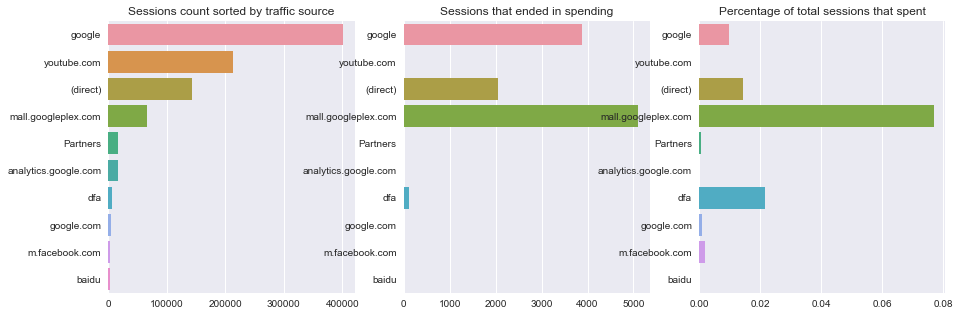

In [162]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.barplot(top_source.values, top_source.index, ax = ax1)
ax1.set_title('Sessions count sorted by traffic source')
sns.barplot(top_source_T.values, top_source_T.index, ax = ax2)
ax2.set_title('Sessions that ended in spending')
sns.barplot(np.divide(top_source_T.values, top_source.values ), top_source_T.index, ax = ax3)
ax3.set_title('Percentage of total sessions that spent')
show()

### Notes:
- youtube and mall.googleplex.com

I will address these in the following slides

### Exploration of referral traffic by site.
- What are the top sites where referrals comes from?
- How well do they convert to sessions that purchase?

In [208]:
ref_source_c = train_df.loc[train_df['channelGrouping'] == 'Referral'].groupby('trafficSource.source').count()['spent_bool'].sort_values(ascending=False)[:10]
ref_top_index = [i for i in ref_source_c.index[:10]]
ref_source_p = train_df.loc[train_df['channelGrouping'] == 'Referral'].groupby('trafficSource.source').sum().loc[ref_top_index, ['spent_bool']]['spent_bool']
ref_source_c.index = ref_top_index
ref_source_p.index = ref_top_index

In [285]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,8))
# sns.barplot(ref_source_c.values, ref_source_c.index, ax = ax)
# sns.barplot(ref_source_p.values, ref_source_p.index, ax = ax2)
g = sns.barplot(np.divide(ref_source_p.values, ref_source_c.values), ref_source_p.index, ax = ax)
for i, v in enumerate(ref_source_c):
    g.text(.085, i, '{:.1f}'.format(np.divide(ref_source_p.values, ref_source_c.values)[i]*100) + '% of ' + str(v))
ax.set_title('Percentage of sessions spending from referrals')

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



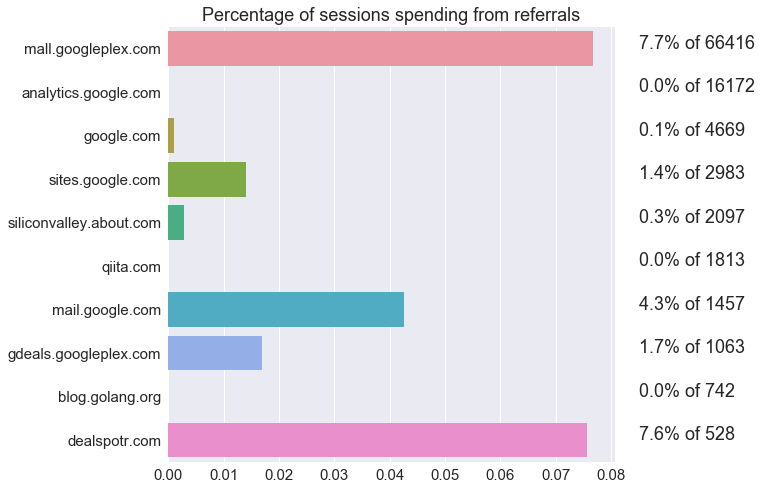

In [286]:
show()

### summary
- mall.googleplex.com contributes to most of the referral sessions that end in purchases. (~8%)
- dealspotr.com and gmail worth further exploration.

## Exploration of paid search traffic

In [150]:
ps_source_c = train_df.loc[train_df['trafficSource.medium'] == 'cpc'].groupby('trafficSource.source').count()['spent_bool'].sort_values(ascending=False)[:5]
ps_top_index = [i for i in ps_source_c.index[:5]]
ps_source_p = train_df.loc[train_df['trafficSource.medium'] == 'cpc'].groupby('trafficSource.source').sum().loc[ps_top_index, ['spent_bool']]['spent_bool']
ps_source_c.index = ps_top_index
ps_source_p.index = ps_top_index

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

/Users/fanggot/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning:

invalid value encountered in true_divide



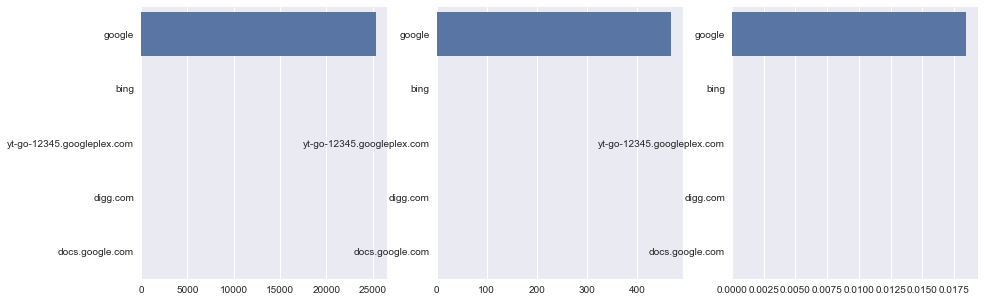

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.barplot(ps_source_c.values, ps_source_c.index, ax = ax1)
sns.barplot(ps_source_p.values, ps_source_p.index, ax = ax2)
sns.barplot(np.divide(ps_source_p.values,ps_source_c.values), ps_source_p.index, ax = ax3)
show()

### takeaways:
- All but one cpc paid search come from google. That other one come from Bing.

### Exploration of traffic from display.

In [212]:
dir_source_c = train_df.loc[train_df['trafficSource.medium'] == 'cpm'].groupby('trafficSource.source').count()['spent_bool'].sort_values(ascending=False)[:5]
dir_top_index = [i for i in dir_source_c.index[:5]]
dir_source_p = train_df.loc[train_df['trafficSource.medium'] == 'cpm'].groupby('trafficSource.source').sum().loc[dir_top_index, ['spent_bool']]['spent_bool']
dir_source_c.index = dir_top_index
dir_source_p.index = dir_top_index

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

/Users/fanggot/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning:

invalid value encountered in true_divide



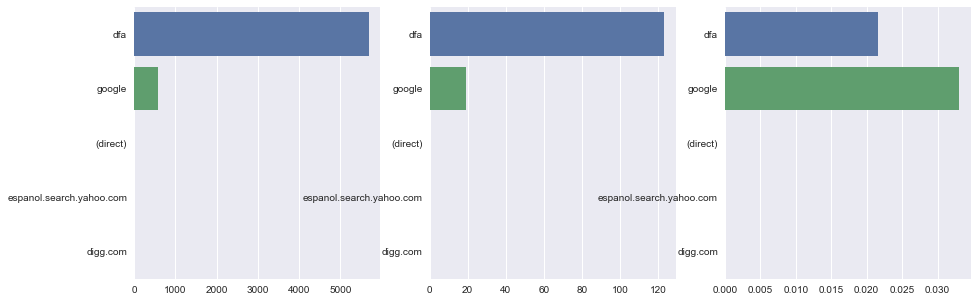

In [213]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.barplot(dir_source_c.values, dir_source_c.index, ax = ax1)
sns.barplot(dir_source_p.values, dir_source_p.index, ax = ax2)
sns.barplot(np.divide(dir_source_p.values,dir_source_c.values), dir_source_p.index, ax = ax3)
show()

### summary
- dfa (Doubleclick for Advertisers) performs pretty well

### Exploration of traffic from social networks and social media

In [214]:
soc_source_c = train_df.loc[train_df['channelGrouping'] == 'Social'].groupby('trafficSource.source').count()['spent_bool'].sort_values(ascending=False)[:5]
soc_top_index = [i for i in soc_source_c.index[:5]]
soc_source_p = train_df.loc[train_df['channelGrouping'] == 'Social'].groupby('trafficSource.source').sum().loc[soc_top_index, ['spent_bool']]['spent_bool']
soc_source_c.index = soc_top_index
soc_source_p.index = soc_top_index

In [216]:
soc_source_c

youtube.com       212602
m.facebook.com      3365
facebook.com        2296
reddit.com          2022
quora.com           1546
Name: spent_bool, dtype: int64

In [287]:
fig, ax = plt.subplots(figsize=(8,8))
# sns.barplot(soc_source_c.values, soc_source_c.index, ax = ax1)
# sns.barplot(soc_source_p.values, soc_source_p.index, ax = ax2)
g = sns.barplot(np.divide(soc_source_p.values,soc_source_c.values), soc_source_p.index, ax = ax)
for i, v in enumerate(soc_source_c):
    g.text(.0095, i, '{:.1f}'.format(np.divide(soc_source_p.values, soc_source_c.values)[i]*100) + '% of ' + str(v))
ax.set_title('Percentage of social sessions purchasing')

/Users/fanggot/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



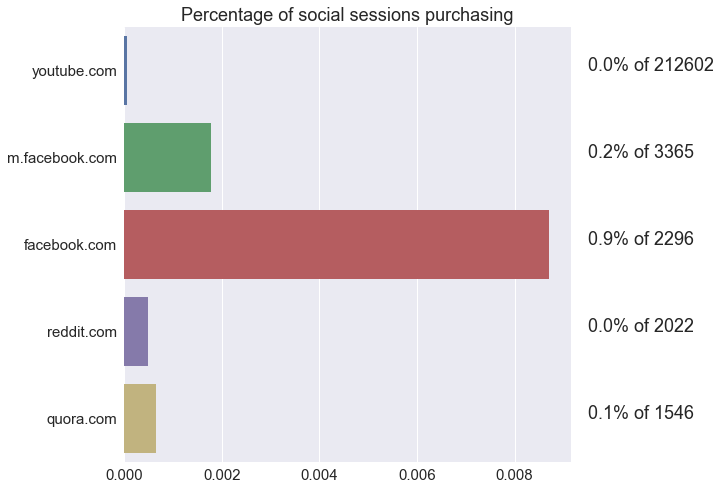

In [288]:
show()

### Summary

- Social traffic from youtube very rarely results in purchases. (11 out of 200k, not sure why)
- In general, social networks and social medias don't result in much spending.

## Summary
- Referrals from mall.googleplex.com is the main source of sessions that end in purchases
- Session coming from social networks, especially from youtube, performs poorly
- Paid search and Displayed results performs well compared to organic search/direct traffic

## Suggestions:
- Place more resources into "mall.googleplex.com" site to attract more users from that site. 
- Explore promotions through email and dealspotr to increast traffic count.
- Reconsider strategies on ads placed on social media and social networks.

##### Feedback of mine  (Oct 10)
- label the graphs
- referrals clarifications (coming from other domain)
- order: moves definition
- graphs (scale very confusing)
    - coloring also
    - maybe not display next to each other
- affiliate: selling another business' product and getting commission.

##### Feedback of Johnny  (Oct 10)
- code too fast (maybe ignore code parts)
- what is the difference between off the market
- list num versis price
- historical SXSW to confirm
- average day listed per year.

##### Feedback of miki  (Oct 10)
- show num of features
- why not one sided?
- nonattending include non-admitted?
- pageviews on what?
- put graph title
- amount of difference